HDF5 版の XGBoost

In [1]:
# ライブラリの皆さん
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.cross_validation import cross_val_score, StratifiedKFold
import matplotlib.pyplot as plt
import time
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# 入力ファイルの皆さん
TRAINS = [
    "../hdf/train_categorical.hdf",
    "../hdf/train_numeric.hdf",
    "../hdf/train_date_L0_normalized.hdf",
    "../hdf/train_date_L1_normalized.hdf",
    "../hdf/train_date_L2_normalized.hdf",
    "../hdf/train_date_L3_normalized.hdf",
    "../hdf/train_date_min_max.hdf",
    "../hdf/train_date_L0_min_max.hdf",
    "../hdf/train_date_L1_min_max.hdf",
    "../hdf/train_date_L2_min_max.hdf",
    "../hdf/train_date_L3_min_max.hdf",
    "../hdf/train_categorical_L3_S32_F3854_decomposite.hdf",
    "../hdf/train_numeric_L1_S24_F1844_extract.hdf",
    "../hdf/train_numeric_L1_S24_F1723_-0.12.hdf",
    "../hdf/train_numeric_L1_S24_F1723_extract.hdf",
    "../hdf/train_S24_C_md5.hdf"
]
TESTS = []
for file in TRAINS:
    TESTS.append(file.replace("train", "test"))
RESPONSE = "../hdf/train_response.hdf"

In [3]:
%%time
# 重要度を見てみる
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
columns = X.columns
X = X.sample(frac=0.7)
y = pd.read_hdf(RESPONSE).loc[X.index].values.ravel()
X = X.values

CPU times: user 24.5 s, sys: 8.98 s, total: 33.5 s
Wall time: 33.5 s


CPU times: user 24min 49s, sys: 7.05 s, total: 24min 56s
Wall time: 1min 57s


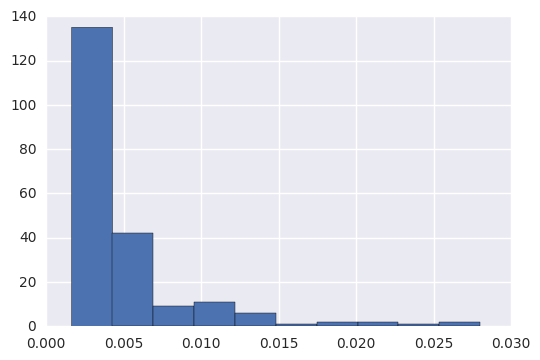

In [4]:
%%time
clf = XGBClassifier(base_score=0.005)
clf.fit(X, y)
plt.hist(clf.feature_importances_[clf.feature_importances_>0])

In [5]:
important_indices = np.where(clf.feature_importances_>0.001)[0]
important_columns = [columns[i] for i in important_indices]
important_columns

['L3_S32_F3854',
 'L0_S0_F4',
 'L0_S0_F12',
 'L0_S0_F14',
 'L0_S0_F20',
 'L0_S0_F22',
 'L0_S1_F24',
 'L0_S1_F28',
 'L0_S2_F44',
 'L0_S2_F48',
 'L0_S2_F56',
 'L0_S2_F60',
 'L0_S2_F64',
 'L0_S3_F96',
 'L0_S3_F100',
 'L0_S4_F104',
 'L0_S4_F109',
 'L0_S5_F116',
 'L0_S6_F122',
 'L0_S6_F132',
 'L0_S9_F170',
 'L0_S10_F259',
 'L0_S11_F282',
 'L0_S11_F290',
 'L0_S11_F310',
 'L0_S11_F314',
 'L0_S11_F318',
 'L0_S11_F322',
 'L0_S11_F326',
 'L0_S12_F346',
 'L0_S12_F348',
 'L0_S12_F350',
 'L0_S12_F352',
 'L0_S13_F354',
 'L0_S15_F397',
 'L0_S15_F415',
 'L0_S16_F426',
 'L0_S17_F431',
 'L0_S17_F433',
 'L0_S19_F455',
 'L0_S20_F461',
 'L0_S23_F623',
 'L1_S24_F839',
 'L1_S24_F867',
 'L1_S24_F930',
 'L1_S24_F1036',
 'L1_S24_F1102',
 'L1_S24_F1118',
 'L1_S24_F1122',
 'L1_S24_F1130',
 'L1_S24_F1145',
 'L1_S24_F1207',
 'L1_S24_F1212',
 'L1_S24_F1298',
 'L1_S24_F1406',
 'L1_S24_F1426',
 'L1_S24_F1467',
 'L1_S24_F1494',
 'L1_S24_F1498',
 'L1_S24_F1512',
 'L1_S24_F1520',
 'L1_S24_F1565',
 'L1_S24_F1567',
 'L1_S2

In [6]:
X = pd.concat((pd.read_hdf(filename) for filename in TRAINS), axis=1)
y = pd.read_hdf(RESPONSE)

In [7]:
X = X.loc[:, important_columns]

In [8]:
X = X.values
y = y.values.ravel()

In [9]:
%%time
# 予測して Cross Validation
clf = XGBClassifier(max_depth=6, base_score=0.005)
cv = StratifiedKFold(y, n_folds=3)
predictions = np.ones(y.shape[0])
for i, (train, test) in enumerate(cv):
    predictions[test] = clf.fit(X[train], y[train]).predict_proba(X[test])[:, 1]
    print("fold {}, ROC AUC: {:.3f}".format(i, roc_auc_score(y[test], predictions[test])))
print(roc_auc_score(y, predictions))

fold 0, ROC AUC: 0.725
fold 1, ROC AUC: 0.705
fold 2, ROC AUC: 0.709
0.712727259673
CPU times: user 59min 43s, sys: 4.58 s, total: 59min 48s
Wall time: 4min 5s


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:516: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(var_yt * var_yp)


0.251814695361
CPU times: user 26.5 s, sys: 16 ms, total: 26.5 s
Wall time: 26.5 s


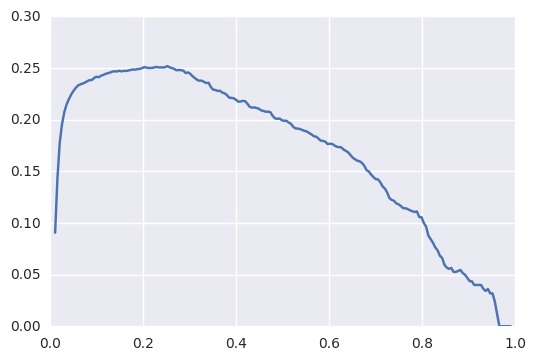

In [10]:
%%time
# MCC 最適化
thresholds = np.linspace(0.01, 0.99, 200)
mcc = np.array([matthews_corrcoef(y, predictions > thr) for thr in thresholds])
plt.plot(thresholds, mcc)
best_threshold = thresholds[mcc.argmax()]
print(mcc.max())

In [11]:
# この時点での当たり具合を出力
tmp_threshold = best_threshold
response = pd.read_hdf(RESPONSE)
response["prediction"] = predictions
predicted_one = response[response["prediction"] > tmp_threshold].groupby("Response").count()
predicted_one.rename(columns={"prediction":"Predict 1.0"}, inplace=True)
predicted_zero = response[response["prediction"] <= tmp_threshold].groupby("Response").count()
predicted_zero.rename(columns={"prediction":"Predict 0.0"}, inplace=True)
pd.concat([predicted_one, predicted_zero], axis=1)

,Predict 1.0,Predict 0.0
Response,,
0.0,1292,1175576
1.0,1012,5867


提出用データを生成する

In [ ]:
# テストデータ読み込み
X = pd.concat((pd.read_hdf(filename) for filename in TESTS), axis=1)
X = X.loc[:, columns]
index = X.index
X = X.values
# 0 or 1 に正規化
predictions = (clf.predict_proba(X)[:, 1] > best_threshold).astype(np.int8)

In [ ]:
# 提出データを生成
sub = pd.DataFrame(index=index.astype(np.int32), columns=[])
sub["Response"] = predictions
sub.to_csv("submission.csv.gz", compression="gzip")